In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (precision_recall_fscore_support, plot_confusion_matrix, plot_precision_recall_curve,
                             confusion_matrix,precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay)

In [2]:
df = pd.read_csv('../data/loan_data.csv')

In [3]:
df.columns = [x.replace('.','_') for x in df.columns]
df.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid'],
      dtype='object')

In [4]:
df['fully_paid'] = 1 - df.not_fully_paid
df.drop('not_fully_paid', axis=1, inplace=True)

In [5]:
def get_preds(classifier, X_test, y_test, threshold):
    y_preds = classifier.predict_proba(X_test)
    y_preds = y_preds[:,1]
    y_preds = 1 * (y_preds > threshold)
    return y_preds   

In [6]:
def find_threshold(estimator, X_train, y_train, scoring='f1'):
    best_thresholds=[0]*5
    scores = cross_validate(estimator, X_train, y_train, scoring = scoring, return_estimator=True)
    for i in range(5):
        estimator_i = scores['estimator'][i]
        yhat = estimator_i.predict_proba(X_train)
        yhat = yhat[:,1]
        precision, recall, thresholds = precision_recall_curve(y_train,yhat)
        fscores = 2*precision*recall/(precision+recall)
        ix = np.argmax(fscores)
        best_thresholds[i] = thresholds[ix]
    return np.mean(best_thresholds)

In [7]:
def print_accuracy_results(y_true, y_preds):
    correct_classification = 1 - np.absolute(y_true - y_preds)
    scoring_df = pd.DataFrame({'y_values': y_true, 'correct_classification': correct_classification})
    zeros = scoring_df[scoring_df.y_values == 0]
    ones = scoring_df[scoring_df.y_values == 1]
    print("The percentage of fully_paid predicted correctly: ",100*ones.correct_classification.sum()/ones.shape[0])
    print("The percentage of not fully_paid predicted correctly: ",100*zeros.correct_classification.sum()/zeros.shape[0])

In [8]:
def print_scores(classifier, X_test, y_test, threshold=None, beta=1.0):
    if threshold is None:
        y_preds = classifier.predict(X_test)
    else:
        y_preds = get_preds(classifier, X_test, y_test, threshold)
        
    scores = precision_recall_fscore_support(y_preds, y_test, beta=beta, average='binary')
    print("precision score: ",scores[0])
    print("recall score: ", scores[1])
    print("f1 score: ", scores[2])
    print('-'*50)
    print_accuracy_results(y_test, y_preds)

# Ordinal encoding the categorical

In [9]:
X = df.drop('fully_paid', axis = 1)
y = df.fully_paid

In [10]:
le = LabelEncoder()

In [11]:
X['purpose'] = le.fit_transform(X.purpose.values)

# Splitting the data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=675, test_size=0.2)

# Base Model

In [13]:
rf1 = RandomForestClassifier()

In [14]:
rf1.fit(X_train,y_train)

RandomForestClassifier()

In [15]:
print_scores(rf1, X_test, y_test)

precision score:  0.9876314162028448
recall score:  0.8449735449735449
f1 score:  0.9107499287140005
--------------------------------------------------
The percentage of fully_paid predicted correctly:  98.76314162028447
The percentage of not fully_paid predicted correctly:  2.0066889632107023


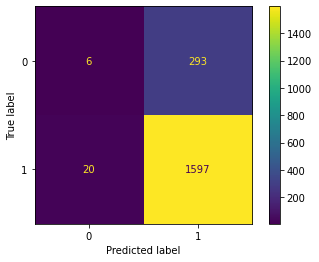

In [16]:
plot_confusion_matrix(rf1 ,X_test, y_test)

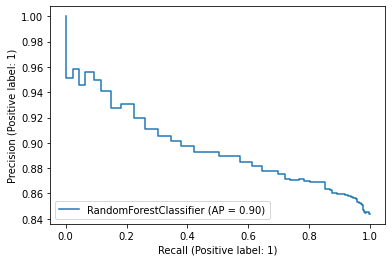

In [17]:
plot_precision_recall_curve(rf1 ,X_test, y_test)

In [33]:
rf1.feature_importances_

array([0.01800918, 0.04306653, 0.1048517 , 0.11541107, 0.1092108 ,
       0.11126915, 0.08137436, 0.11387763, 0.11276504, 0.11313723,
       0.0547636 , 0.01319203, 0.00907169])

In [34]:
X.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec'],
      dtype='object')

# Using balanced weights

In [18]:
rf2 = RandomForestClassifier(class_weight='balanced')

In [19]:
rf2.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced')

In [20]:
print_scores(rf2, X_test, y_test)

precision score:  0.9931972789115646
recall score:  0.8439306358381503
f1 score:  0.9125000000000001
--------------------------------------------------
The percentage of fully_paid predicted correctly:  99.31972789115646
The percentage of not fully_paid predicted correctly:  0.6688963210702341


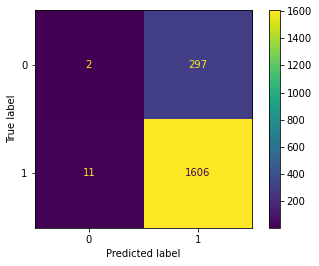

In [21]:
plot_confusion_matrix(rf2 ,X_test, y_test)

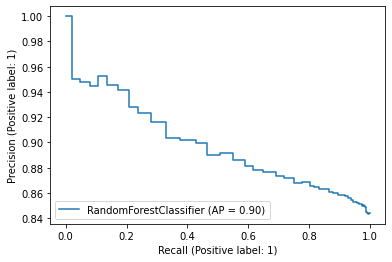

In [22]:
plot_precision_recall_curve(rf2 ,X_test, y_test)

Using class weights, balanced made the random forest worse

# Improving the model with hyperparameter tuning

In [23]:
rf3 = RandomForestClassifier()
params = {
    'criterion':['entropy','gini'],
    'max_depth':[3,4,7,None],
    'class_weight':['balanced','balanced_subsample',None]
}

In [24]:
grid = GridSearchCV(rf3,params,scoring='f1')

In [25]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 4, 7, None]},
             scoring='f1')

In [26]:
grid.best_score_

0.9129356554782742

In [27]:
grid.best_params_

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None}

In [28]:
print_scores(grid.best_estimator_, X_test, y_test)

precision score:  0.9969078540507111
recall score:  0.8453067645516518
f1 score:  0.9148694665153234
--------------------------------------------------
The percentage of fully_paid predicted correctly:  99.69078540507113
The percentage of not fully_paid predicted correctly:  1.3377926421404682


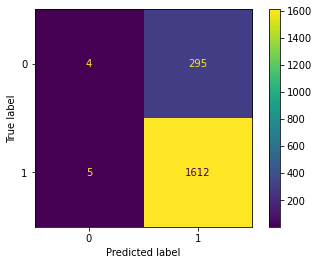

In [29]:
plot_confusion_matrix(grid.best_estimator_ ,X_test, y_test)

In [ ]:
# try oversampling and undersampling here.

# Improving the base model by moving the treshold

In [30]:
rf_t = find_threshold(rf1, X_train, y_train)
rf_t

0.49800000000000005

In [31]:
print_scores(rf1, X_test, y_test, threshold=0.75)

precision score:  0.782312925170068
recall score:  0.8712121212121212
f1 score:  0.8243727598566308
--------------------------------------------------
The percentage of fully_paid predicted correctly:  78.2312925170068
The percentage of not fully_paid predicted correctly:  37.458193979933114


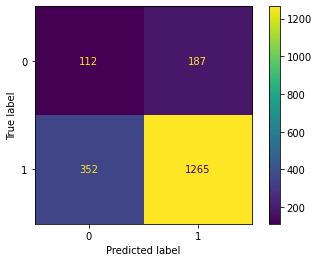

In [35]:
y_preds = get_preds(rf1, X_test, y_test, threshold=0.75)
rf1_cm = confusion_matrix(y_test, y_preds)
cm_disp = ConfusionMatrixDisplay(rf1_cm, display_labels=rf1.classes_)
cm_disp.plot()

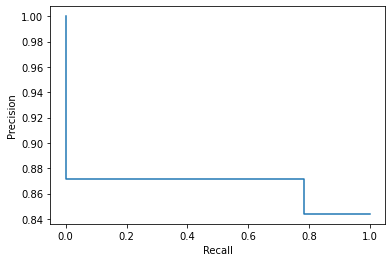

In [36]:
precision, recall, _ = precision_recall_curve(y_test, y_preds)
pr_disp = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_disp.plot()